<a href="https://colab.research.google.com/github/NARAEIM/tp2-da/blob/hm98112/%EC%9C%A0%ED%95%98%EB%AF%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import seaborn

drive.mount('da')

Drive already mounted at da; to attempt to forcibly remount, call drive.mount("da", force_remount=True).


In [2]:
import pandas as pd

#데이터 불러오기
click_stream_new = pd.read_csv('/content/da/MyDrive/archive/click_stream_new.csv')
customer = pd.read_csv('/content/da/MyDrive/archive/customer.csv')



In [3]:
#데이터 불러오기
product = pd.read_csv('/content/da/MyDrive/archive/product.csv', skiprows = [6043, 6568, 7398, 7938, 9025, 10263, 10426, 10904, 11372, 11944, 14111, 14531, 15075, 29905, 31624, 33019, 35747, 35961, 37769, 38104, 38274, 38403])
transaction_new = pd.read_csv('/content/da/MyDrive/archive/transaction_new.csv')

# 1.function


### [1]


날짜/시간 추출 함수

In [4]:
import datetime
from datetime import datetime

def date_time_split(time_str):
  
  datetime_obj = datetime.fromisoformat(time_str)
  
  # 날짜와 시간 추출
  date = datetime_obj.strftime("%Y-%m-%d")
  time = datetime_obj.strftime("%H:%M:%S")
  
  return date, time


### [2]

click_stream 데이터의 session_id 특성의 value_counts() 값을 기준으로 정렬한 데이터에 대해 각 event 발생 날짜/(같은 날짜일 경우)시간 차이 계산함수

In [5]:
def check_time_delta(x):
    #value_counts 함수로 정렬한 인덱스를 key로 설정
    key = click_stream_new.value_counts('session_id').index[x]

    #key로 검색한 데이터에 대해 시간순으로 정렬
    filtered_data= click_stream_new[click_stream_new['session_id'] == key]
    filtered_data = filtered_data.sort_values(['event_date_new', 'event_time_new'])
    filtered_data.reset_index(inplace = True, drop = True)

    #날짜 차이 계산
    deltas_date = []
    for i in range(len(filtered_data)-1):
        delta = datetime.strptime(filtered_data['event_date_new'][i+1], '%Y-%m-%d') - datetime.strptime(filtered_data['event_date_new'][i], '%Y-%m-%d')
        deltas_date.append(delta.days)
    
    date_sum = sum(deltas_date)
    date_avg = date_sum/len(deltas_date)

    #시간 차이 계산 / 날짜가 변경 된 경우에는 차이를 계산하지 않고 '-' 를 입력함.
    deltas_time = []
    for i in range(len(filtered_data)-1):
        if filtered_data['event_date_new'][i+1] == filtered_data['event_date_new'][i]:
            delta = datetime.strptime(filtered_data['event_time_new'][i+1], '%H:%M:%S') - datetime.strptime(filtered_data['event_time_new'][i], '%H:%M:%S')
            delta = delta.seconds/60
        else:
            delta = '-'
        deltas_time.append(delta)

    numeric_values = pd.to_numeric(deltas_time, errors='coerce')  # 숫자가 아닌 값은 NaN으로 변환
    numeric_values= pd.DataFrame(numeric_values).dropna()
    time_avg = numeric_values.mean()

    return date_sum, date_avg, time_avg

### [3]

click_stream 데이터의 session_id 특성의 value_counts() 값을 기준으로 정렬한 데이터에 대해 각 event 발생 시간 차이 계산함수

In [6]:
def check_time_delta2(x):

    #value_counts 함수로 정렬한 인덱스를 key로 설정
    key = click_stream_new.value_counts('session_id').index[x]

    #key로 검색한 데이터에 대해 시간순으로 정렬
    filtered_data= click_stream_new[click_stream_new['session_id'] == key]
    filtered_data = filtered_data.sort_values('event_time')
    filtered_data.reset_index(inplace = True, drop = True)
    
    #세션의 각 이벤트 사이의 초 계산
    times = []
    for row in filtered_data['event_time']:
      time = row.split('.')[0]
      times.append(time)

    deltas_seconds = []
    for i in range(len(times)-1):
      delta = datetime.strptime(times[i+1], '%Y-%m-%dT%H:%M:%S') - datetime.strptime(times[i], '%Y-%m-%dT%H:%M:%S')
      deltas_seconds.append(delta.seconds)
    
    return deltas_seconds

### [4]

 click_stream 데이터에서 특정 이벤트의 연월 데이터 추출하는 함수

In [78]:
def event_extract(eventname):
  #event_name 이 HOMPAGE 인 데이터만 추출
  visit = click_stream_new[click_stream_new['event_name'] == eventname]

  #각 방문에 대해 연도/월 추출 하여 각각 year/month 로 이름 변환
  year = pd.to_datetime(visit['event_date_new']).dt.year.rename('year')
  month = pd.to_datetime(click_stream_new['event_date_new']).dt.month.rename('month')

  df_visit = pd.DataFrame(visit.groupby([year,month])['event_date_new'].count().rename(eventname))
  return df_visit


### [5]

사이트별 방문객 수 시계열 그래프 그리는 함수

In [77]:
import matplotlib.pyplot as plt

def plot_visitors(df):
  #index의 year와 month를 하나의 문자열로 연결
  year_month = df.index.get_level_values('year').astype(str) + '-' + df.index.get_level_values('month').astype(str) 
  
  # 방문객 수 데이터
  visitors = df[df.columns[0]]  
  
  # 시계열 그래프 그리기
  plt.figure(figsize=(20, 6))
  plt.plot(year_month, visitors)
  plt.xlabel('Year-Month')
  plt.ylabel('Visitors')
  plt.title(f'MONTHLY "{df.columns[0]}" PAGE VISITORS')
  plt.xticks(rotation=45)  # x축 라벨 회전
  return plt.show()

# 2.click_stream

In [7]:
#데이터 살펴보기
click_stream_new[:3]

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## feature

<h1>click_stream_new</h1>
session_id: 세션 아이디<br>
event_name: 사건의 이름<br>
event_time: 사건이 일어난 시간<br>
event_id: 사건 아이디<br>
traffic_source: 접속 방법<br>
product_id: 물건 아이디<br>
quantiy: 물건 개수<br>
item_price: 물건 가격<br>
payment_status: 결제 상태<br>
search_keywords: 검색 키워드<br>
promo_code: 프로모션 코드<br>
promo_amount: 프로모션을 통한 할인 가격


In [8]:
len(click_stream_new)

12833602

## value_counts

In [9]:
#각 특성 별 value_counts
for column in click_stream_new.columns:
  print(click_stream_new[column].value_counts())
  print('______________________________')

65383bfb-5535-445f-ab52-aec4658eb0bd    650
eb310630-8d65-4c59-8a33-a386b891ec74    650
d46877e2-9e20-4277-8698-647dee913a14    539
12489f38-0fc1-4b80-9fe4-b267c4413ae7    539
c22cb71e-f232-4930-9d59-85340bd98336    519
                                       ... 
e9e6daf7-9369-4261-b51f-049d7736ead4      2
663c5044-5144-4d83-b34a-0573aa36cee8      2
582cf298-4b62-4ff8-8d50-2a371ec8608f      2
a3454191-6eeb-4b8a-b8bd-45cd0824ab1b      2
fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c      2
Name: session_id, Length: 895203, dtype: int64
______________________________
CLICK          2498038
HOMEPAGE       2487126
ADD_TO_CART    1937157
SCROLL         1663571
ITEM_DETAIL    1290396
SEARCH         1173266
BOOKING         852582
PROMO_PAGE      604931
ADD_PROMO       326535
Name: event_name, dtype: int64
______________________________
2021-05-02T11:28:41.047631Z    451
2021-06-27T04:54:12.223694Z    348
2021-01-27T16:31:07.016439Z    283
2022-03-27T23:50:33.575140Z    168
2021-07-20T11:05:55.743696Z  

## EDA

In [10]:
# 세션 아이디의 중복이 많은 데이터 살펴보기 앞 20 개
click_stream_new[click_stream_new['session_id'] == 'd46877e2-9e20-4277-8698-647dee913a14'][:20]

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount
8483986,d46877e2-9e20-4277-8698-647dee913a14,HOMEPAGE,2021-10-27T02:02:43.401969Z,3f2e27d3-01ce-469b-88dc-85353dd0715e,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8483987,d46877e2-9e20-4277-8698-647dee913a14,ADD_TO_CART,2021-10-31T04:17:14.401969Z,70947540-10ea-40e8-ab40-d5e05237907c,MOBILE,20248.0,1.0,326549.0,NaN,NaN,NaN,NaN
8483988,d46877e2-9e20-4277-8698-647dee913a14,ADD_TO_CART,2021-11-04T06:39:31.401969Z,80d56b40-704e-4f89-bc35-0c7725a01b99,MOBILE,5261.0,3.0,310500.0,NaN,NaN,NaN,NaN
8483989,d46877e2-9e20-4277-8698-647dee913a14,ADD_PROMO,2021-11-08T08:52:09.401969Z,e92b3ca1-9007-4405-83df-0a686fa24cc3,MOBILE,NaN,NaN,NaN,NaN,NaN,BUYMORE,4632.0
8483990,d46877e2-9e20-4277-8698-647dee913a14,BOOKING,2021-11-16T14:00:44.401969Z,c8655ddf-0472-41f4-a2c4-7307d3b02bb2,MOBILE,NaN,NaN,NaN,Success,NaN,NaN,NaN
8483991,d46877e2-9e20-4277-8698-647dee913a14,CLICK,2021-10-31T04:21:58.401969Z,eae58fed-5007-4897-bf72-8b8898157deb,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8483992,d46877e2-9e20-4277-8698-647dee913a14,HOMEPAGE,2021-11-16T17:58:44.401969Z,d24f2ab9-717b-4852-bd6d-14d8f5b922f1,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8483993,d46877e2-9e20-4277-8698-647dee913a14,ITEM_DETAIL,2021-11-16T22:00:38.401969Z,fcf1fa1f-5c0e-4565-a726-84598e07fe48,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8483994,d46877e2-9e20-4277-8698-647dee913a14,HOMEPAGE,2021-11-17T02:04:53.401969Z,ea364ebc-6ee2-48b5-855d-b74dda812184,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8483995,d46877e2-9e20-4277-8698-647dee913a14,HOMEPAGE,2021-11-17T06:05:19.401969Z,bd2c283d-8e67-4638-a364-7985f6c98141,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# 세션 아이디의 중복이 많은 데이터 살펴보기 뒤 20 개
click_stream_new[click_stream_new['session_id'] == 'd46877e2-9e20-4277-8698-647dee913a14'][-20:]

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount
8484505,d46877e2-9e20-4277-8698-647dee913a14,HOMEPAGE,2022-02-11T03:17:31.401969Z,dc52bbf2-c49a-48c4-b286-acc387a2d3d5,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8484506,d46877e2-9e20-4277-8698-647dee913a14,HOMEPAGE,2022-02-11T07:18:56.401969Z,1016c2d8-a13e-4fb1-92bf-722da56c9c7f,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8484507,d46877e2-9e20-4277-8698-647dee913a14,HOMEPAGE,2022-02-11T11:25:05.401969Z,2e4d8562-8d54-4460-98e0-b7cd6723be6e,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8484508,d46877e2-9e20-4277-8698-647dee913a14,HOMEPAGE,2022-02-11T15:26:06.401969Z,4d602bf8-fc69-48c0-aa35-cce8d006806b,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8484509,d46877e2-9e20-4277-8698-647dee913a14,CLICK,2022-02-11T19:28:55.401969Z,675de596-329d-4921-afa2-98553149d407,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8484510,d46877e2-9e20-4277-8698-647dee913a14,HOMEPAGE,2022-02-11T23:31:04.401969Z,3ab99012-3d5d-4474-8ca0-6bbef7b6745a,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8484511,d46877e2-9e20-4277-8698-647dee913a14,CLICK,2022-02-12T03:33:48.401969Z,84115233-982a-4bc2-9639-7cb6741b05ac,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8484512,d46877e2-9e20-4277-8698-647dee913a14,HOMEPAGE,2022-02-12T07:38:50.401969Z,a7454a51-6b26-479f-9bfe-3c185341817c,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8484513,d46877e2-9e20-4277-8698-647dee913a14,CLICK,2022-02-12T11:42:05.401969Z,c6901803-cd35-472f-a93f-acf4bb3af97a,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8484514,d46877e2-9e20-4277-8698-647dee913a14,HOMEPAGE,2022-02-12T15:41:51.401969Z,7a02f267-d343-4129-bfe3-0120b9473516,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#session_id 가 같은 데이터 중 300개 이상인 개수 확인

value_counts = click_stream_new['session_id'].value_counts()
result = value_counts[value_counts >= 300]
result

65383bfb-5535-445f-ab52-aec4658eb0bd    650
eb310630-8d65-4c59-8a33-a386b891ec74    650
d46877e2-9e20-4277-8698-647dee913a14    539
12489f38-0fc1-4b80-9fe4-b267c4413ae7    539
c22cb71e-f232-4930-9d59-85340bd98336    519
230b1fd1-595a-4d28-a75f-23ff686df302    483
756d0b19-5870-4bb8-aa74-611f85f9804f    477
17347e17-4a5a-4233-9763-ced580dec559    461
5842f8ad-0de9-44fe-9033-5f847d45a893    460
874ebe70-c835-4055-aaa8-b3ec4f21cb85    433
66e91a36-c5b4-4a83-9472-5255a47bf37f    429
a93fc441-3efb-4f61-8069-dc42c16a828f    420
be3261d2-fc30-473e-ad18-9a1fd3e032fd    417
8d798040-12a7-4b8e-841f-7cd39b7e4bec    410
13365b64-c5ae-429a-b28b-04e6f11397a6    398
7e303111-398f-45c9-b7ce-0d1b71879b0e    397
c7495f73-a4eb-4f3f-a3a5-b90dcbf972f9    389
7ff267cd-1f6c-45f5-8831-eaa32cd3acab    377
4f6ff090-201d-4e90-9648-e18b6f065df7    376
77b23548-2c35-469a-ba84-07d50bc0950f    367
8bf3a5ac-776a-4d79-8263-573dda22c5ca    367
a62c618a-958f-4207-80d3-9494b50c3d68    365
108f31a9-c0ad-4ed7-9a24-79f9834e

## 전처리

In [13]:
#event_time 에서 시간, 날짜 추출하기(1.function에 있는 함수 [1])
click_stream_event_date = []
click_stream_event_time = []

for row in click_stream_new['event_time']:
 date, time = date_time_split(row[:-1])  #Z가 있는 경우 에러 발생하여 제거
 click_stream_event_date.append(date)
 click_stream_event_time.append(time)

In [14]:
#추출한 시간/날짜 특성 추가
click_stream_new['event_date_new'] = click_stream_event_date
click_stream_new['event_time_new'] = click_stream_event_time

In [15]:
#결과 확인
click_stream_new

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount,event_date_new,event_time_new
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06,15:54:32
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06,16:03:57
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01,12:05:10
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,15315.0,4.0,313529.0,NaN,NaN,NaN,NaN,2019-09-01,12:06:33
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,NaN,NaN,NaN,Success,NaN,NaN,NaN,2019-09-01,12:15:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12833597,ad1063b0-a6e5-40a9-aed6-d1b45741e571,SEARCH,2021-06-07T04:37:53.354381Z,4b3b91a5-9bda-44de-87dc-153367071dfc,MOBILE,NaN,NaN,NaN,NaN,Bekas,NaN,NaN,2021-06-07,04:37:53
12833598,64585e37-3fe7-48d7-b79b-ebcb70230eb2,HOMEPAGE,2021-05-05T11:44:14.985835Z,ab0acc87-9578-408a-b47f-c46996b8b52f,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-05,11:44:14
12833599,64585e37-3fe7-48d7-b79b-ebcb70230eb2,ADD_TO_CART,2021-05-05T11:53:10.985835Z,230d7b67-9934-42f9-9509-b330ac6ae777,MOBILE,19820.0,1.0,88918.0,NaN,NaN,NaN,NaN,2021-05-05,11:53:10
12833600,64585e37-3fe7-48d7-b79b-ebcb70230eb2,BOOKING,2021-05-05T12:10:09.135142Z,8996ce49-c5dd-41ed-9231-28bfdb634cbe,MOBILE,NaN,NaN,NaN,Success,NaN,NaN,NaN,2021-05-05,12:10:09


# 3.customer

In [16]:
#데이터 확인
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_id         100000 non-null  int64  
 1   first_name          100000 non-null  object 
 2   last_name           100000 non-null  object 
 3   username            100000 non-null  object 
 4   email               100000 non-null  object 
 5   gender              100000 non-null  object 
 6   birthdate           100000 non-null  object 
 7   device_type         100000 non-null  object 
 8   device_id           100000 non-null  object 
 9   device_version      100000 non-null  object 
 10  home_location_lat   100000 non-null  float64
 11  home_location_long  100000 non-null  float64
 12  home_location       100000 non-null  object 
 13  home_country        100000 non-null  object 
 14  first_join_date     100000 non-null  object 
dtypes: float64(2), int64(1), object(12)

## feature

<h1>customer</h1>
customer_id: 고객 아이디<br>
first_name: 이름<br>
last_name: 성<br>
username: 유저 이름<br>
email: 이메일<br>
gender: 성별<br>
birthdate: 생일<br>
device_type: 기기 종류<br>
device_id: 장치 아이디<br>
device_version: 디바이스 버전<br>
home_location_lat: 집 위도<br>
home_location_long: 집 경도<br>
home_location: 집 위치<br>
home_country: 나라<br>
first_join_date: 처음 가입한 날짜 <br>

## value_counts

In [17]:
#각 특성 별 value_counts
for column in customer.columns:
  print(customer[column].value_counts())
  print('______________________________')

2870     1
78034    1
81629    1
46669    1
56483    1
        ..
16708    1
30297    1
41212    1
25652    1
40573    1
Name: customer_id, Length: 100000, dtype: int64
______________________________
Rahmi      560
Putri      557
Eka        380
Ade        373
Kani       339
          ... 
Harsana     53
Dacin       53
Budi        50
Eluh        48
Edward      48
Name: first_name, Length: 707, dtype: int64
______________________________
Susanti       1028
Palastri      1002
Andriani       998
Rahmawati      997
Yolanda        992
              ... 
Iswahyudi      302
Hidayanto      302
Nababan        302
Tampubolon     301
Widodo         293
Name: last_name, Length: 173, dtype: int64
______________________________
671a0865-ac4e-4dc4-9c4f-c286a1176f7e    1
e32e587e-1146-4b78-aec4-91f739f58682    1
f713b56e-788e-4b07-959c-863b04462d44    1
1b44bafa-a611-4aa1-821e-c522d6d3769c    1
94973be4-399a-454c-aaff-a7ecd5465e56    1
                                       ..
9e636014-be43-4427-bb10-9

# 4.product

## feature

<h1>product</h1><br>
id: 아이디<br>
gender: 성별<br>
masterCategory: 상위 카테고리<br>
subCategory: 하위 카테고리<br>
articleType: 기사 타입<br>
baseColour: 기본 색상<br>
seasion: 계절<br>
year: 연도<br>
usage: 용도<br>
productDisplayName: 제품명<br>



## value_counts

In [18]:
#각 특성 별 value_counts
for column in product.columns:
  print(product[column].value_counts())
  print('______________________________')


15970    1
36826    1
13953    1
6198     1
12881    1
        ..
8845     1
16466    1
22653    1
7031     1
51623    1
Name: id, Length: 44424, dtype: int64
______________________________
Men       22147
Women     18631
Unisex     2161
Boys        830
Girls       655
Name: gender, dtype: int64
______________________________
Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: masterCategory, dtype: int64
______________________________
Topwear                     15402
Shoes                        7343
Bags                         3055
Bottomwear                   2694
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         

# 5.transaction


## feature

<h1>transaction</h1>
created_at: 거래 발생 시각<br>
customer_id: 고객 아이디<br>
booking_id: 예약 아이디<br>
sessoin_id: 세션 아이디<br>
payment_method: 결제 수단<br>
payment_status: 결제 상태<br>
promo_amount: 프로모션 할인 가격<br>
promo_code: 프로모션 코드<br>
shipment_fee: 배송비<br>
shipment_date_limit: 배송 완료 한계시각<br>
shipment_location_lat: 배송지 위도<br>
shipment_location_long: 배송지 경도<br>
total_amount: 합계가격<br>
product_id: 상품 아이디<br>
quantity: 수량<br>
item_price: 상품가격<br>


## value_counts

In [19]:
#각 특성 별 value_counts
for column in transaction_new.columns:
  print(transaction_new[column].value_counts())
  print('______________________________')

2019-09-03T16:41:47.368861Z    51
2021-04-05T07:12:47.036003Z    49
2017-08-25T02:19:25.172007Z    48
2021-04-07T16:41:55.222630Z    48
2022-07-14T19:10:41.302769Z    43
                               ..
2018-06-11T15:16:04.312665Z     1
2018-07-06T16:12:39.312665Z     1
2018-07-31T16:36:16.312665Z     1
2018-08-25T16:26:52.312665Z     1
2019-12-19T12:47:14.701215Z     1
Name: created_at, Length: 852584, dtype: int64
______________________________
43202    807
29496    749
82237    716
10167    693
69740    673
        ... 
2934       1
4363       1
52112      1
92794      1
58180      1
Name: customer_id, Length: 50705, dtype: int64
______________________________
b9d670fe-1ae0-4c79-b214-588225fd201e    51
8414d299-c1fd-4333-a622-00da2895703c    49
e7d064c8-2b57-479a-a848-d0046b3a2065    48
7750eee5-8968-4ed4-a557-91d7f03e08ce    48
1b77d403-c552-490f-a1e9-4f02634f56b0    43
                                        ..
cf0c2bcc-44bd-45f1-afbb-a12a09e17b25     1
509ce639-b44e-4e7e-a446-45

## 전처리

In [20]:
transaction_new['created_at'].sort_values()

1254461    2016-06-30T23:18:44.792905Z
1201589    2016-07-01T02:53:26.720195Z
1201590    2016-07-01T02:53:26.720195Z
1201721    2016-07-01T09:45:51.803842Z
1254460    2016-07-01T22:32:45.218400Z
                      ...             
985626     2022-07-31T23:58:50.469277Z
985568     2022-07-31T23:58:53.821469Z
985766     2022-07-31T23:59:03.408424Z
985569     2022-07-31T23:59:19.821469Z
985570     2022-07-31T23:59:45.821469Z
Name: created_at, Length: 1254585, dtype: object

In [21]:
transaction_date = []
transaction_time = []
for row in transaction_new['created_at']:
  date,time = date_time_split(row[:-1])
  transaction_date.append(date)
  transaction_time.append(time)

In [22]:
transaction_new['created_date'] = transaction_date
transaction_new['created_time'] = transaction_time

In [23]:
sum((transaction_new['shipment_fee'] + (transaction_new['item_price']) * transaction_new['quantity']  - transaction_new['promo_amount'] ) == transaction_new['total_amount'])

706668

In [24]:
transaction_new['total_amount']

0           199832
1           155526
2           550696
3           271012
4           198753
            ...   
1254580     226820
1254581     359203
1254582    1158159
1254583     184143
1254584     365963
Name: total_amount, Length: 1254585, dtype: int64

In [25]:
transaction_new

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price,created_date,created_time
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832,54728,1,191247,2018-07-29,15:22:01
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526,16193,1,145526,2018-07-30,12:40:22
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696,53686,4,135174,2018-09-15,11:51:17
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012,20228,1,271012,2018-11-01,11:23:48
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753,55220,1,198753,2018-12-18,11:20:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254580,2021-09-21T22:10:05.074873Z,25121,66f02fa4-c62e-497a-8b6e-be239009b50a,484eecde-9f4a-42de-a8df-7ce6668101f4,Debit Card,Failed,0,NaN,0,2021-09-27T00:43:40.992167Z,-6.869535,111.077145,226820,30642,2,113410,2021-09-21,22:10:05
1254581,2021-12-09T07:35:18.222046Z,34829,ccde6b83-ee42-4cce-b2cd-976574886eac,954e1211-4d45-4d0b-ba84-53e80119592c,OVO,Success,5010,AZ2022,10000,2021-12-12T07:52:44.803822Z,-8.677264,115.176947,359203,19394,1,354213,2021-12-09,07:35:18
1254582,2021-12-11T01:20:36.944593Z,99645,5bcd3434-1dc6-44bb-ae63-fd19714cbd6c,e6e6c108-abd0-49a2-b0a5-691117f9cfe1,Credit Card,Success,2181,WEEKENDSERU,5000,2021-12-12T13:28:22.848703Z,-6.185498,106.831093,1158159,13079,4,288835,2021-12-11,01:20:36
1254583,2019-12-18T11:01:09.623382Z,87319,af7f291a-b01b-4bfd-89a9-237b16368b15,bb6e5426-a3f3-426a-b99d-79173eaa234b,Credit Card,Success,4503,AZ2022,0,2019-12-23T22:56:46.831720Z,-7.155977,110.891858,184143,11312,1,188646,2019-12-18,11:01:09


# 6.EDA


In [26]:
key = click_stream_new.value_counts('session_id').index[0]
filtered_data= click_stream_new[click_stream_new['session_id'] == key]

In [27]:
filtered_data = filtered_data.sort_values(['event_date_new', 'event_time_new'])
filtered_data.reset_index(inplace = True, drop = True)

In [28]:
deltas_date = []
for i in range(len(filtered_data)-1):
  delta = datetime.strptime(filtered_data['event_date_new'][i+1], '%Y-%m-%d') - datetime.strptime(filtered_data['event_date_new'][i], '%Y-%m-%d')
  deltas_date.append(delta.days)

In [29]:
filtered_data

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount,event_date_new,event_time_new
0,65383bfb-5535-445f-ab52-aec4658eb0bd,HOMEPAGE,2021-04-19T07:56:25.706561Z,f10d4b1a-b44f-4b26-a02c-d6a1c46084a1,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-19,07:56:25
1,65383bfb-5535-445f-ab52-aec4658eb0bd,CLICK,2021-04-21T01:40:32.706561Z,b140ca89-a6d1-4875-ade8-f87dbfb4bcfa,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-21,01:40:32
2,65383bfb-5535-445f-ab52-aec4658eb0bd,ADD_TO_CART,2021-04-21T01:48:02.706561Z,b5eec39e-4ad0-4e90-8473-c47d3d89a78d,MOBILE,39775.0,1.0,178232.0,NaN,NaN,NaN,NaN,2021-04-21,01:48:02
3,65383bfb-5535-445f-ab52-aec4658eb0bd,ADD_TO_CART,2021-04-22T19:34:21.706561Z,652bea1e-29d2-40da-9d72-c9e36dffdb95,MOBILE,7063.0,1.0,438552.0,NaN,NaN,NaN,NaN,2021-04-22,19:34:21
4,65383bfb-5535-445f-ab52-aec4658eb0bd,ADD_PROMO,2021-04-22T19:37:44.706561Z,7d555d88-7e85-4906-9b77-f79abd7607eb,MOBILE,NaN,NaN,NaN,NaN,NaN,BUYMORE,6903.0,2021-04-22,19:37:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,65383bfb-5535-445f-ab52-aec4658eb0bd,HOMEPAGE,2021-06-29T06:09:24.706561Z,397ffaf3-9de1-46d3-8b22-0baa4cc7f2ea,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-29,06:09:24
646,65383bfb-5535-445f-ab52-aec4658eb0bd,ITEM_DETAIL,2021-06-29T08:00:56.706561Z,dfb7493c-9dfb-452b-8ce9-985d89b25c15,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-29,08:00:56
647,65383bfb-5535-445f-ab52-aec4658eb0bd,ITEM_DETAIL,2021-06-29T09:56:14.706561Z,399536b9-15b4-45c4-8dc2-0e786fa0fdad,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-29,09:56:14
648,65383bfb-5535-445f-ab52-aec4658eb0bd,PROMO_PAGE,2021-06-29T11:49:51.706561Z,6309d744-2878-4fea-8c89-545f654c1531,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-29,11:49:51


In [30]:
sum(deltas_date)

71

In [31]:
sum(deltas_date)/len(deltas_date)

0.10939907550077041

In [32]:
deltas_time = []
for i in range(len(filtered_data)-1):
  if filtered_data['event_date_new'][i+1] == filtered_data['event_date_new'][i]:
    delta = datetime.strptime(filtered_data['event_time_new'][i+1], '%H:%M:%S') - datetime.strptime(filtered_data['event_time_new'][i], '%H:%M:%S')
    delta = delta.seconds
  else:
    delta = '-'
  deltas_time.append(delta)

In [33]:
deltas_time

['-',
 450,
 '-',
 203,
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 6859,
 6950,
 6823,
 6809,
 6943,
 6775,
 6776,
 6682,
 6876,
 '-',
 6782,
 6867,
 6891,
 6758,
 6905,
 6831,
 6931,
 6855,
 6909,
 6807,
 6893,
 '-',
 6804,
 6819,
 6805,
 6565,
 6805,
 6814,
 6705,
 6839,
 6895,
 6728,
 6710,
 6759,
 '-',
 7008,
 6804,
 6751,
 6895,
 6872,
 6837,
 6792,
 6753,
 6590,
 6811,
 6771,
 6959,
 '-',
 6754,
 6825,
 6850,
 6866,
 6770,
 6941,
 6966,
 6741,
 6818,
 6628,
 6823,
 '-',
 6774,
 6994,
 6699,
 6793,
 6922,
 6710,
 6953,
 6882,
 6852,
 6918,
 6930,
 6872,
 '-',
 6785,
 6776,
 6753,
 6804,
 6896,
 6839,
 6868,
 6713,
 6732,
 6858,
 6767,
 6808,
 '-',
 6942,
 6728,
 6803,
 6974,
 6703,
 6851,
 6754,
 6845,
 6722,
 6880,
 6821,
 '-',
 6901,
 6946,
 6654,
 6933,
 6769,
 6799,
 6859,
 6816,
 6699,
 6918,
 6914,
 6782,
 '-',
 6713,
 6930,
 6825,
 6798,
 6835,
 6679,
 6771,
 6940,
 6915,
 6921,
 6867,
 6524,
 '-',
 6817,
 6825,
 6789,
 6684,
 6868,
 6748,
 6742,
 6740,
 6806,
 6764,


In [34]:
numeric_values = pd.to_numeric(deltas_time, errors='coerce')  # 숫자가 아닌 값은 NaN으로 변환
numeric_values= pd.DataFrame(numeric_values).dropna()
average = numeric_values.mean()

In [35]:
average

0    6798.831919
dtype: float64

In [36]:
check_time_delta(4)

(20,
 0.03861003861003861,
 0    36.4509
 dtype: float64)

In [37]:
click_stream_new.value_counts('session_id')

session_id
65383bfb-5535-445f-ab52-aec4658eb0bd    650
eb310630-8d65-4c59-8a33-a386b891ec74    650
12489f38-0fc1-4b80-9fe4-b267c4413ae7    539
d46877e2-9e20-4277-8698-647dee913a14    539
c22cb71e-f232-4930-9d59-85340bd98336    519
                                       ... 
b587aaa4-7dd1-47fb-8044-b98066955482      2
a9e814a1-e8d6-4580-849b-44e6fb655540      2
3f753166-c4a3-429e-a76d-c63c991719e1      2
714f7eb0-e9c1-4527-ab61-b9a9005ed09f      2
aa3d6530-7ced-4fb9-899b-9ae0be6f9292      2
Length: 895203, dtype: int64

In [38]:
click_stream_new[click_stream_new['session_id'] == click_stream_new.value_counts('session_id').index[-20]]

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount,event_date_new,event_time_new
9029540,d91c5049-d6c9-4f46-8a44-37a94d3c8850,HOMEPAGE,2020-01-07T18:19:45.816025Z,e6517f46-e61a-40cd-badb-16f5feb69f2e,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-07,18:19:45
9029541,d91c5049-d6c9-4f46-8a44-37a94d3c8850,CLICK,2020-01-07T18:25:20.816025Z,278640f3-d209-4d18-958f-233eb670ce81,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-07,18:25:20


In [39]:
pd.merge(transaction_new[['session_id', 'created_date', 'created_time']], click_stream_new[['session_id', 'event_date_new', 'event_time_new']], on = 'session_id', how = 'right')[:20]

,session_id,created_date,created_time,event_date_new,event_time_new
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,NaN,NaN,2019-09-06,15:54:32
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,NaN,NaN,2019-09-06,16:03:57
2,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01,12:15:29,2019-09-01,12:05:10
3,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01,12:15:29,2019-09-01,12:06:33
4,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01,12:15:29,2019-09-01,12:15:29
5,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01,12:15:29,2019-09-01,12:07:00
6,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01,12:15:29,2019-09-01,12:08:27
7,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01,12:15:29,2019-09-01,12:09:49
8,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01,12:15:29,2019-09-01,12:11:06
9,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01,12:15:29,2019-09-01,12:12:19


In [40]:
# pd.reset_option('display.max_rows', None)

# click_stream_new[click_stream_new['session_id'] == click_stream_new.value_counts('session_id').index[50]]

In [41]:

click_stream_new.groupby('session_id').filter(lambda x: len(x) == 2)

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount,event_date_new,event_time_new
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06,15:54:32
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06,16:03:57
64731,3cc534be-0a43-425f-a131-e18f2f7a9c99,HOMEPAGE,2019-06-18T05:11:17.728216Z,3419259e-635e-49f9-9cd9-e55258ab3670,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-18,05:11:17
64732,3cc534be-0a43-425f-a131-e18f2f7a9c99,ITEM_DETAIL,2019-06-18T05:17:04.728216Z,bab7ddeb-78b5-448f-a6f2-ea35802d7d64,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-18,05:17:04
140001,507336b2-07a3-4618-8e6c-ca1dd4192dba,HOMEPAGE,2018-03-19T06:22:35.699564Z,4be4e81d-db64-46a5-a419-4ed5fedb7426,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-19,06:22:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12833261,4a3a58c6-4ff5-417d-9d80-e1a9a2fd7cf9,SCROLL,2021-09-04T00:24:14.693223Z,b7e31929-38ef-44fc-a719-2f76857bada0,WEB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-04,00:24:14
12833290,2f51f07f-2b5e-49da-bbd6-5ca6c193418b,HOMEPAGE,2021-04-29T12:30:07.155099Z,16a6613b-cda9-413a-b62c-91ce9d471d50,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-29,12:30:07
12833291,2f51f07f-2b5e-49da-bbd6-5ca6c193418b,HOMEPAGE,2021-04-29T12:35:58.155099Z,1d338f5b-8761-4bff-a3f8-265b08f4ab0f,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-29,12:35:58
12833436,9790b1e5-20ea-45bb-af1c-990d939145fb,HOMEPAGE,2017-01-17T15:24:48.281542Z,de91aa68-33b4-4f43-b86e-18d412ee7c75,WEB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-17,15:24:48


In [42]:
x = pd.merge(click_stream_new['session_id'], transaction_new[['session_id', 'customer_id']], on = 'session_id', how = 'left' )

In [43]:
sum(x['customer_id'].isnull())

370598

In [44]:
click_stream_new[click_stream_new['session_id'] == click_stream_new['session_id'].unique()[1]]

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount,event_date_new,event_time_new
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01,12:05:10
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,15315.0,4.0,313529.0,NaN,NaN,NaN,NaN,2019-09-01,12:06:33
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,NaN,NaN,NaN,Success,NaN,NaN,NaN,2019-09-01,12:15:29
5,7d440441-e67a-4d36-b324-80ffd636d166,SEARCH,2019-09-01T12:07:00.322763Z,c952142b-4fe9-4694-ad7f-21a5d1bed9ca,MOBILE,NaN,NaN,NaN,NaN,Dress Kondangan,NaN,NaN,2019-09-01,12:07:00
6,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:08:27.322763Z,365b3840-9647-4bf5-917f-f0bec3d05332,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01,12:08:27
7,7d440441-e67a-4d36-b324-80ffd636d166,ITEM_DETAIL,2019-09-01T12:09:49.322763Z,1a1e3548-108e-4520-bf04-1b01d43a72cb,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01,12:09:49
8,7d440441-e67a-4d36-b324-80ffd636d166,SCROLL,2019-09-01T12:11:06.322763Z,f7246095-b094-46c1-b2ac-bcfd080146c3,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01,12:11:06
9,7d440441-e67a-4d36-b324-80ffd636d166,ITEM_DETAIL,2019-09-01T12:12:19.322763Z,74a000dc-b931-4c59-abcc-02e991623bc1,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01,12:12:19
10,7d440441-e67a-4d36-b324-80ffd636d166,ITEM_DETAIL,2019-09-01T12:13:36.322763Z,85b3589a-5281-48a2-b2f3-a39a7de69f60,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01,12:13:36


## 방문객 수 확인

In [80]:
# click_stream 데이터에서 특정 이벤트의 연월 데이터 추출하기(1.function에 있는 함수 [4])

home = event_extract("HOMEPAGE")
cart = event_extract("ADD_TO_CART")
item = event_extract("ITEM_DETAIL")
serch = event_extract("SERCH")
booking = event_extract("BOOKING")
promo = event_extract("PROMO_PAGE")
add_promo = event_extract("ADD_PROMO")

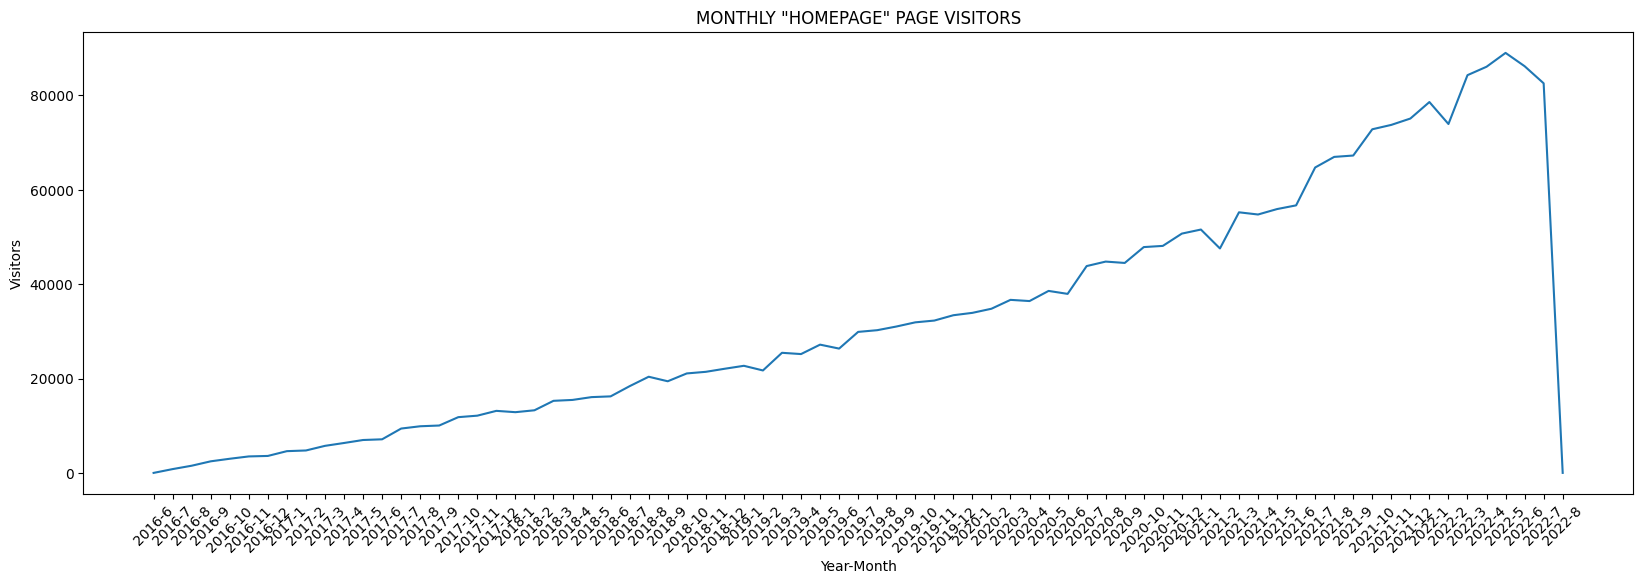

In [81]:
#그래프 그리기(1.function에 있는 함수 [5])
plot_visitors(home)

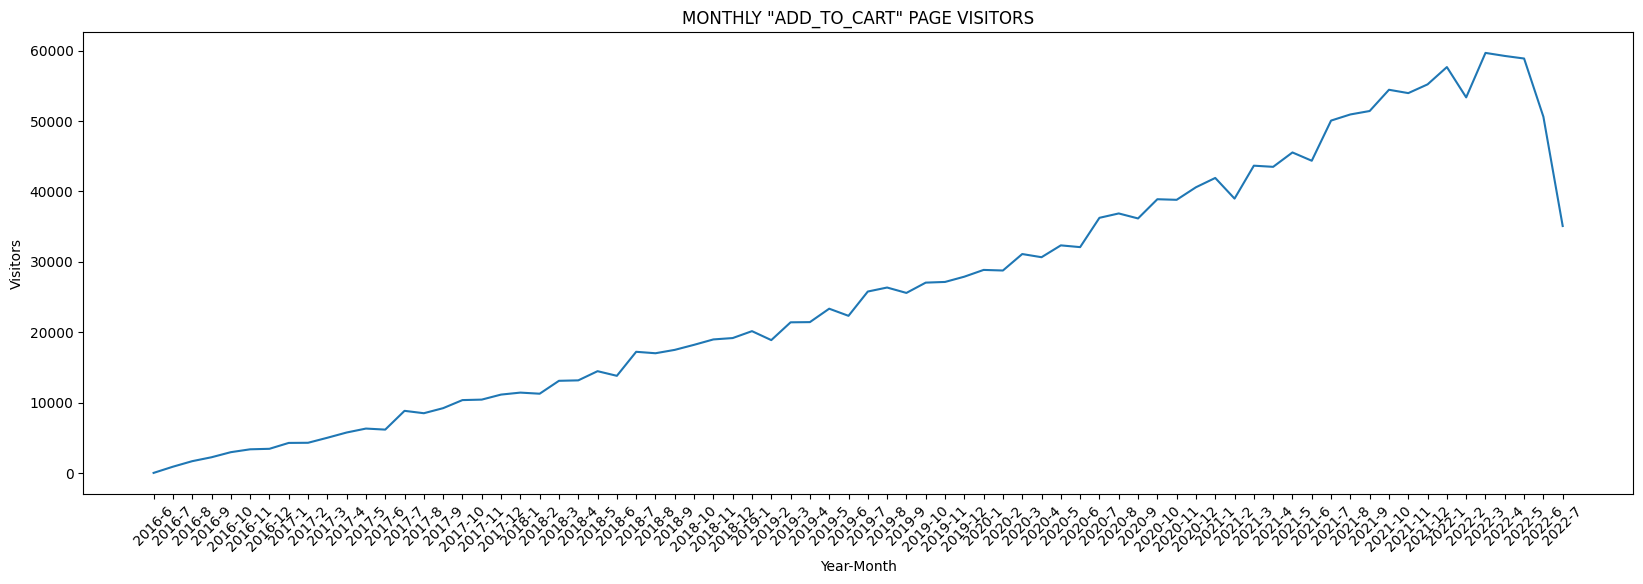

In [82]:
plot_visitors(cart)

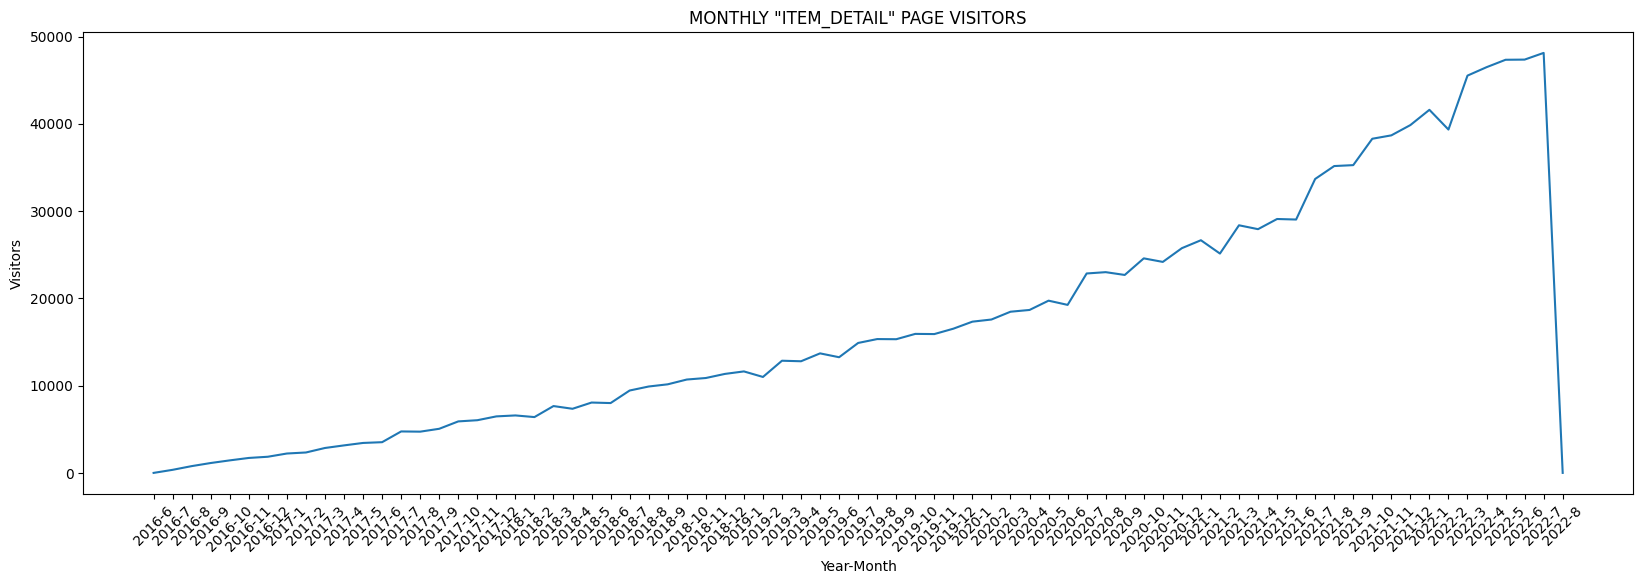

In [83]:
plot_visitors(item)

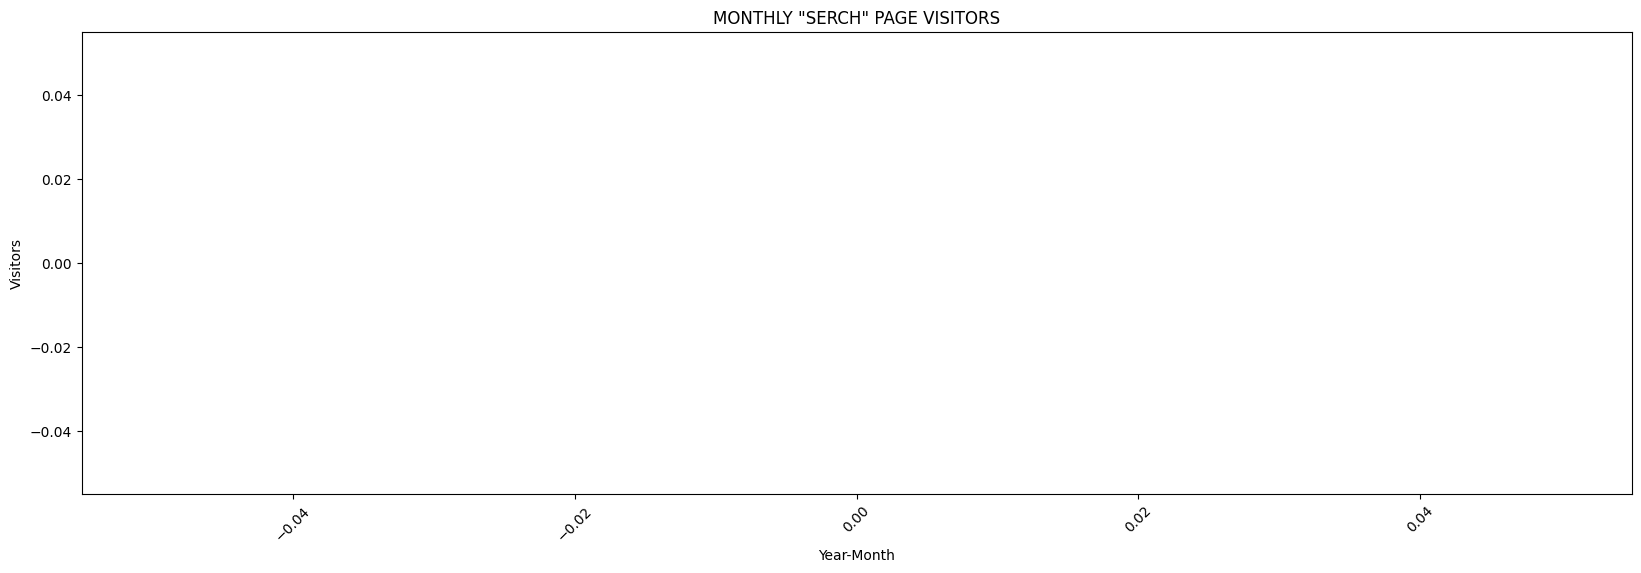

In [84]:
plot_visitors(serch)

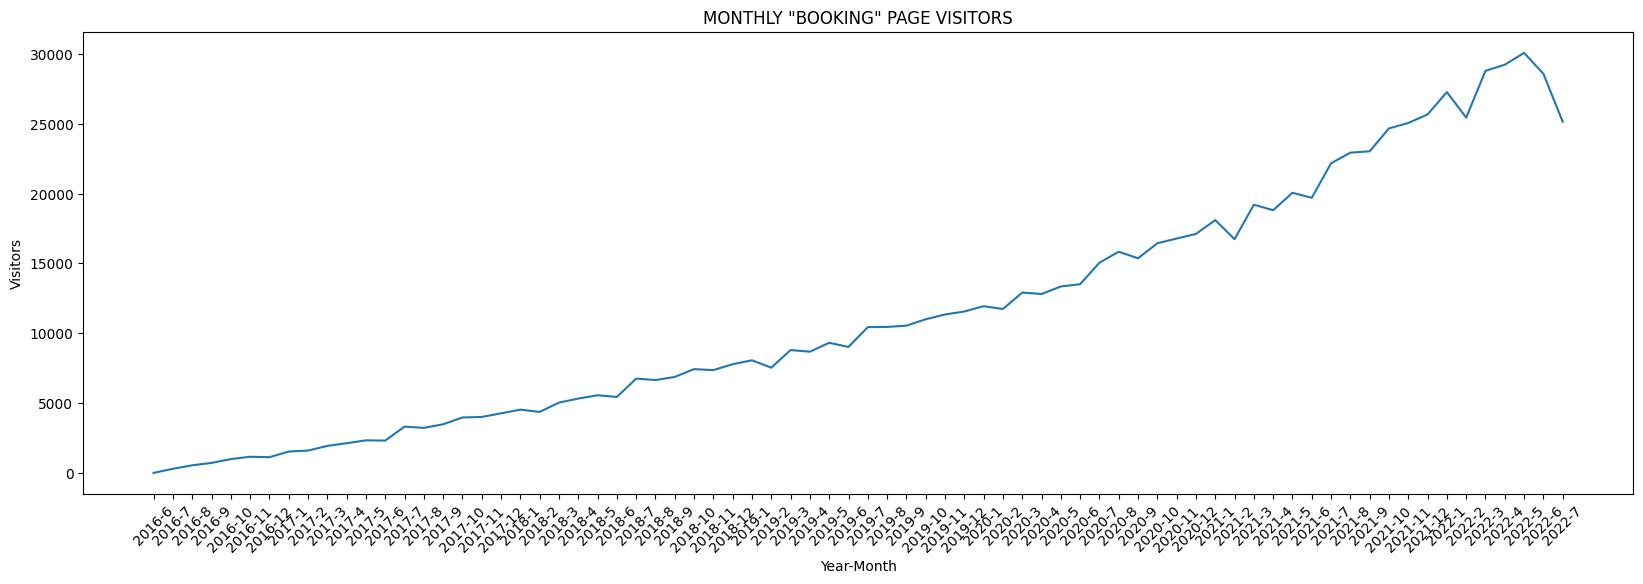

In [85]:
plot_visitors(booking)

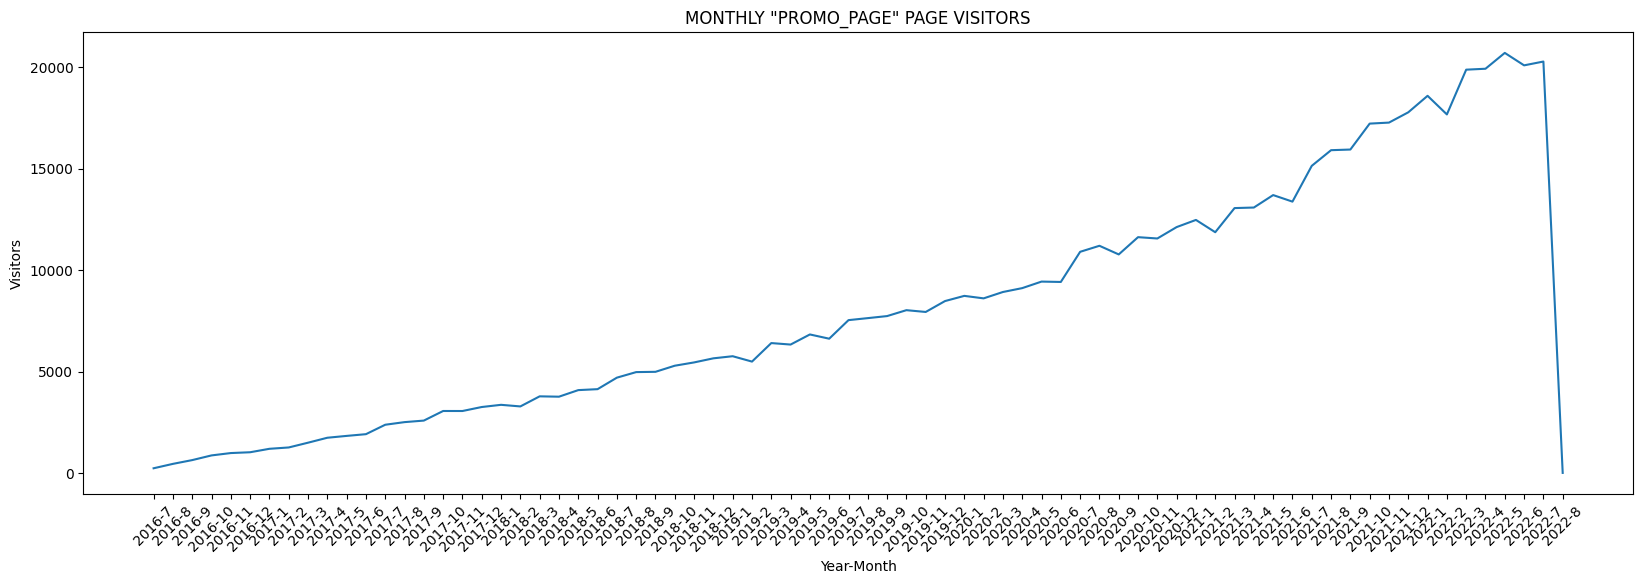

In [86]:
plot_visitors(promo)

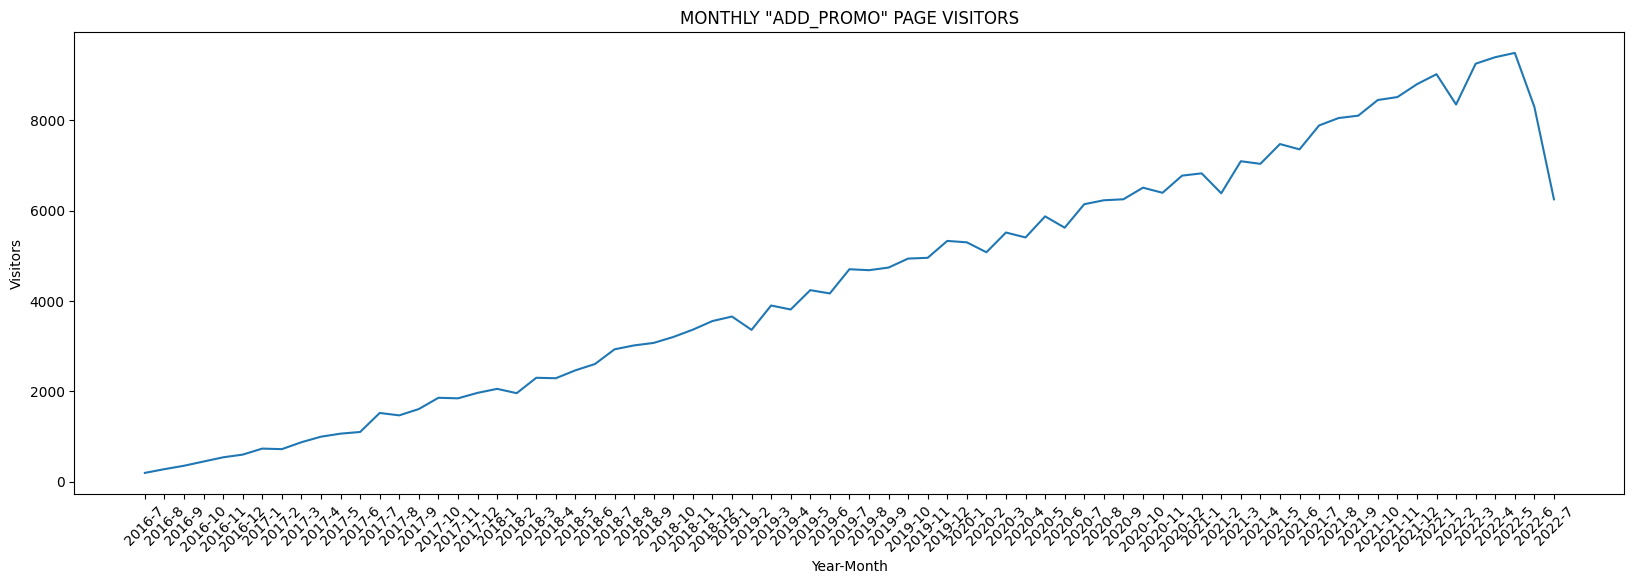

In [87]:
plot_visitors(add_promo)
       